In [1]:
import numpy as np
import pandas as pd
import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 図のフォント指定
plt.rcParams['font.family'] = 'Times New Roman'

#　ランダムシードの設定
if __name__ == '__main__':
    np.random.seed(2023)
    torch.manual_seed(2023)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''クラス'''

# データセット作成用クラス
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, features, labels):
        self.features_values = df[features].values
        self.labels = df[labels].values

    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.features_values)
    
    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        features_x = torch.FloatTensor(self.features_values[idx])
        labels = torch.FloatTensor(self.labels[idx])
        return features_x, labels
    
    
# ネットワークの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 全結合層
        self.l1 = nn.Linear(4, 100)
        self.a1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(100)
        self.l2 = nn.Linear(100, 100)
        self.a2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(100)
        self.l3 = nn.Linear(100, 4)
        self.a3 = nn.Sigmoid()
        
    def forward(self, aoa):
        # 全結合層
        x = self.l1(aoa)
        x = self.a1(x)
        x = self.bn1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.bn2(x)
        x = self.l3(x)
        c_val = self.a3(x)
        
        # 受信機位置のベクトル化
        pos_rx1 = torch.tensor(POS_RX[0]).view(-1, 1)
        pos_rx2 = torch.tensor(POS_RX[1]).view(-1, 1)
        pos_rx3 = torch.tensor(POS_RX[2]).view(-1, 1)
        pos_rx4 = torch.tensor(POS_RX[3]).view(-1, 1)

        # 最小二乗法
        I = torch.eye(2) # 単位行列
        
        pos_list = []

        for i in np.arange(len(aoa)):
            # 初期化
            R = 0
            q = 0

            # 方向ベクトル（AoA）
            n1 = torch.tensor([math.cos(math.radians(aoa[i][0])), math.sin(math.radians(aoa[i][0]))]).view(-1, 1)
            n2 = torch.tensor([math.cos(math.radians(aoa[i][1])), math.sin(math.radians(aoa[i][1]))]).view(-1, 1)
            n3 = torch.tensor([math.cos(math.radians(aoa[i][2])), math.sin(math.radians(aoa[i][2]))]).view(-1, 1)
            n4 = torch.tensor([math.cos(math.radians(aoa[i][3])), math.sin(math.radians(aoa[i][3]))]).view(-1, 1)

            # ベクトルから行列
            N1 = torch.mm(n1, n1.view(-1, 2))
            N2 = torch.mm(n2, n2.view(-1, 2))
            N3 = torch.mm(n3, n3.view(-1, 2))
            N4 = torch.mm(n4, n4.view(-1, 2))

            R = c_val[i][0]*(I - N1) + c_val[i][1]*(I - N2) + c_val[i][2]*(I - N3) + c_val[i][3]*(I - N4) # Rの演算
            q = c_val[i][0]*(torch.mm(I - N1, pos_rx1)) + c_val[i][1]*(torch.mm(I - N2, pos_rx2)) + c_val[i][2]*(torch.mm(I - N3, pos_rx3)) + c_val[i][3]*(torch.mm(I - N4, pos_rx4)) # qの演算

            #　Rの擬似逆行列
            R_pinv = torch.linalg.pinv(R)

            # 推定位置
            pos_est = torch.mm(R_pinv, q).view(-1, 2)
            pos_list.append(pos_est[0])
            pos = torch.stack(pos_list)

        return pos
            

'''関数'''

# 生データ→データフレームに変換する関数
def preprocessing_aoa(list_of_path, channel, start_time, end_time): # RX1~RX4のパスのリスト、チャネル、開始時間、終了時間が引数
    
    # 各受信機のdfを格納
    angles = []

    # 各受信機ごとに前処理を実施
    for i in np.arange(len(list_of_path)):
        # カラム
        columns = ["instanceID", "RSSI", "Azimuth", "Elevation", "Reserved parameter", "advertising channel", "Anchor ID", "Userdefinedstrings", "Timestamp"]
        # データフレーム生成
        angle = pd.read_csv(list_of_path[i], sep=',', header=None, names=columns)
        # 方位角を取得してカラム名を受信機番号に対応させる
        angle = angle[['Azimuth', 'RSSI', 'advertising channel', 'Timestamp']].set_axis(['azi_%d' % (i+1), 'rssi_%d' % (i+1), 'channel', 'timestamp'], axis=1).dropna()
        # 60秒から18秒までを抽出
        angle = angle[angle.timestamp > start_time*1000]
        angle = angle[angle.timestamp < end_time*1000]
        # 指定チャネルのデータを抽出
        angle = angle[angle['channel'].isin([channel])]
        # timestampを秒単位に統一
        angle['timestamp'] = (angle['timestamp']//1000).astype('int')
        # 1秒ごとに中央値をとる
        angle= angle.groupby('timestamp').median().astype('int')
        
        angles.append(angle)  # リストに格納
        
    list_of_series = [angles[0]['azi_1'], angles[1]['azi_2'], angles[2]['azi_3'], angles[3]['azi_4'],
                     angles[0]['rssi_1'], angles[1]['rssi_2'], angles[2]['rssi_3'], angles[3]['rssi_4']]  # Seriesに分解して並び替える
    
    df = pd.concat(list_of_series, join='inner', axis=1).reset_index(drop=False)  # joinをinnerにすることで、timestampの等しい行を残して結合

    return df

# データフレームにラベルを追加する関数
def add_label(df, label):
    
    # データフレームの長さ
    length = len(df)
    
    # ラベルのシリーズ
    x_label = pd.Series(np.full(length, label[0]), name = 'x_label')
    y_label = pd.Series(np.full(length, label[1]), name = 'y_label')
    
    rabel_df = pd.concat([x_label, y_label], axis=1)
    
    feature_rabel_df = pd.concat([df, rabel_df], axis=1)
    
    return feature_rabel_df
    

# 角度の基準をx軸に変換する関数
def change_angle_reference(df_aoa):
    df_aoa['azi_1'] = -df_aoa['azi_1']
    df_aoa['azi_2'] = -90 -df_aoa['azi_2']
    df_aoa['azi_3'] = 180 -df_aoa['azi_3']
    df_aoa['azi_4'] = 90 -df_aoa['azi_4']
    
    return df_aoa

# 定数
POS_RX = [[0.0, 2.0], [2.0, 4.0], [4.0, 2.0], [2.0,0.0]]
CHANNEL = 37
START_TIME = 60
END_TIME = 180

In [2]:
'''データフレームの生成'''

list_path = [['dataset/20231004/pos1_rx1.log', 'dataset/20231004/pos1_rx2.log', 'dataset/20231004/pos1_rx3.log', 'dataset/20231004/pos1_rx4.log'],
             ['dataset/20231004/pos2_rx1.log', 'dataset/20231004/pos2_rx2.log', 'dataset/20231004/pos2_rx3.log', 'dataset/20231004/pos2_rx4.log'],
             ['dataset/20231004/pos3_rx1.log', 'dataset/20231004/pos3_rx2.log', 'dataset/20231004/pos3_rx3.log', 'dataset/20231004/pos3_rx4.log'],
             ['dataset/20231004/pos4_rx1.log', 'dataset/20231004/pos4_rx2.log', 'dataset/20231004/pos4_rx3.log', 'dataset/20231004/pos4_rx4.log']]

list_label = [[1.5, 2.5], [2.5, 2.5], [1.5, 1.5], [2.5, 1.5]]

df = []

for i in np.arange(len(list_path)):
    aoa_df = preprocessing_aoa(list_path[i], CHANNEL, START_TIME, END_TIME)
    aoa_df = change_angle_reference(aoa_df)
    aoa_df = add_label(aoa_df, list_label[i])
    df.append(aoa_df.iloc[0:80])

df[0]

,timestamp,azi_1,azi_2,azi_3,azi_4,rssi_1,rssi_2,rssi_3,rssi_4,x_label,y_label
0,60,23,-115,196,117,-49,-58,-62,-56,1.5,2.5
1,61,17,-101,197,117,-49,-57,-62,-57,1.5,2.5
2,62,23,-108,196,117,-52,-57,-62,-57,1.5,2.5
3,63,23,-108,197,116,-52,-57,-60,-58,1.5,2.5
4,65,17,-101,197,123,-52,-59,-64,-58,1.5,2.5
...,...,...,...,...,...,...,...,...,...,...,...
75,149,23,-107,196,117,-49,-57,-62,-57,1.5,2.5
76,150,24,-109,196,123,-49,-57,-62,-57,1.5,2.5
77,151,24,-109,168,117,-49,-57,-63,-58,1.5,2.5
78,152,16,-108,196,123,-52,-57,-63,-57,1.5,2.5


In [3]:
'''データセットの準備'''

# 空リスト
df_train = []
df_val_test = []
df_val = []
df_test = []

# 訓練データと検証&テストデータに分割
for i in np.arange(len(df)):
    train, val_test = train_test_split(df[i], test_size=0.4, random_state=2023)
    df_train.append(train)
    df_val_test.append(val_test)
    
# 検証データとテストデータに分割
for i in np.arange(len(df)):
    val, test = train_test_split(df_val_test[i], test_size=0.8, random_state=2023)
    df_val.append(val)
    df_test.append(test)
    
# 訓練データ，検証データ，テストデータそれぞれ結合
df_train = pd.concat(df_train, ignore_index=True)
df_val = pd.concat(df_val, ignore_index=True)
df_test = pd.concat(df_test, ignore_index=True)

# 特徴量の名前
features = ['azi_1', 'azi_2', 'azi_3', 'azi_4']

# ラベルの名称
label = ['x_label', 'y_label']

# データセットの作成
train_dataset = MyDataset(df_train, features, label)
val_dataset = MyDataset(df_val, features, label)
test_dataset = MyDataset(df_test, features, label)

#訓練データ，検証データ，テストデータのDataLoaderを生成
train_dataloader = DataLoader(train_dataset,
                              batch_size=32,
                              shuffle=True,
                              drop_last=True)

val_dataloader = DataLoader(val_dataset,
                            batch_size=10,
                            shuffle=False)

test_dataloader = DataLoader(test_dataset,
                             batch_size=10,
                             shuffle=False)

In [4]:
'''NNモデルの準備'''
model = Net().to(device)

In [5]:
'''NNの訓練準備'''

# 損失関数
criterion = nn.MSELoss()
# 勾配アルゴリズム
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.0001, # 学習率
                            betas=(0.9, 0.999),
                            amsgrad=True)

# 損失の計算
def compute_loss(t, y):
    return criterion(y, t)

# 訓練用関数
def train_step(x, t):
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

# 検証用関数
def val_step(x, t):
    model.eval() # モデルを推論モードへ切り替え
    preds = model(x)
    loss = criterion(preds, t)

    return loss, preds

# エポック数
epochs = 100

# 損失格納用リスト
hist = {'loss': [], 'val_loss': []}

In [6]:
'''NNモデルの訓練'''

for epoch in range(epochs):
    train_loss = 0.
    val_loss = 0.

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device).view(-1, 2)
        loss, preds = train_step(x, t)
        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device).view(-1, 2)
        loss, preds = val_step(x, t)
        val_loss += loss.item()

    val_loss /= len(val_dataloader)

    hist['loss'].append(train_loss)
    hist['val_loss'].append(val_loss)

    print('epoch: {}, loss: {:.3}, val_loss: {:.3}'.format(
              epoch+1,
              train_loss,
              val_loss
          ))

epoch: 1, loss: 0.181, val_loss: 0.195
epoch: 2, loss: 0.159, val_loss: 0.167
epoch: 3, loss: 0.143, val_loss: 0.156
epoch: 4, loss: 0.133, val_loss: 0.141
epoch: 5, loss: 0.119, val_loss: 0.125
epoch: 6, loss: 0.11, val_loss: 0.11
epoch: 7, loss: 0.102, val_loss: 0.0957
epoch: 8, loss: 0.0913, val_loss: 0.0837
epoch: 9, loss: 0.0842, val_loss: 0.0746
epoch: 10, loss: 0.0775, val_loss: 0.0679
epoch: 11, loss: 0.0722, val_loss: 0.0632
epoch: 12, loss: 0.0722, val_loss: 0.0588
epoch: 13, loss: 0.0695, val_loss: 0.0559
epoch: 14, loss: 0.0647, val_loss: 0.0522
epoch: 15, loss: 0.0648, val_loss: 0.0501
epoch: 16, loss: 0.0559, val_loss: 0.0478
epoch: 17, loss: 0.0534, val_loss: 0.046
epoch: 18, loss: 0.0548, val_loss: 0.0431
epoch: 19, loss: 0.05, val_loss: 0.0416
epoch: 20, loss: 0.0479, val_loss: 0.0396
epoch: 21, loss: 0.0477, val_loss: 0.0384
epoch: 22, loss: 0.0465, val_loss: 0.0366
epoch: 23, loss: 0.0455, val_loss: 0.0353
epoch: 24, loss: 0.0458, val_loss: 0.0345
epoch: 25, loss: 0.

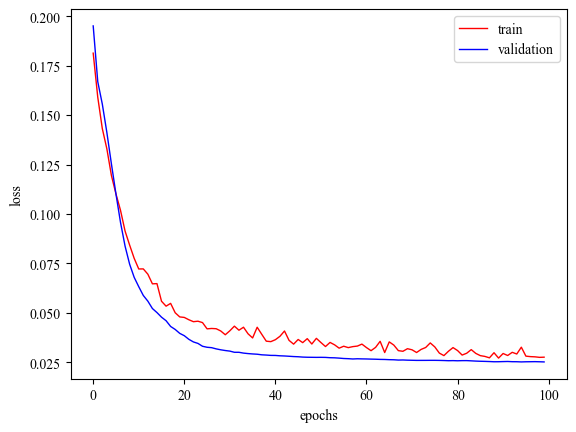

In [7]:
'''学習状況の可視化（val_lossの推移）'''

train_loss = hist['loss']
val_loss = hist['val_loss']

fig = plt.figure()
plt.plot(train_loss, color='red', linewidth=1, label="train")
plt.plot(range(len(val_loss)), val_loss, color='blue', linewidth=1, label="validation")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig("figure/deeplearning_least_square/train_val_loss_1.png")
plt.show()

In [8]:
'''NNモデルの評価'''

# 評価用関数
def test_step(x, t):
    return val_step(x, t)

# 測位結果格納用リスト
nn = []

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device).view(-1, 2)
    loss, preds = test_step(x, t)

    p_t = torch.cat((preds, t), dim=1)

    nn.append(p_t)

In [9]:
'''NNによる測位結果のデータフレーム作成'''
nn = torch.cat(nn, dim=0)
nn = nn.detach().numpy().copy()
nn_columns = ['x_est', 'y_est', 'x_lab', 'y_lab']
nn = pd.DataFrame(nn, columns=nn_columns)
nn

,x_est,y_est,x_lab,y_lab
0,1.463677,2.531433,1.5,2.5
1,1.416252,2.366400,1.5,2.5
2,1.478227,2.527978,1.5,2.5
3,1.474556,2.494127,1.5,2.5
4,1.434835,2.529325,1.5,2.5
...,...,...,...,...
99,2.249778,1.528909,2.5,1.5
100,2.403873,1.609937,2.5,1.5
101,2.515720,1.330029,2.5,1.5
102,2.248811,1.548170,2.5,1.5


In [10]:
'''誤差の列を追加'''
nn['error'] = np.sqrt((nn['x_lab'] - nn['x_est'])**2 + (nn['y_lab'] - nn['y_est'])**2)
nn

,x_est,y_est,x_lab,y_lab,error
0,1.463677,2.531433,1.5,2.5,0.048035
1,1.416252,2.366400,1.5,2.5,0.157679
2,1.478227,2.527978,1.5,2.5,0.035452
3,1.474556,2.494127,1.5,2.5,0.026113
4,1.434835,2.529325,1.5,2.5,0.071460
...,...,...,...,...,...
99,2.249778,1.528909,2.5,1.5,0.251886
100,2.403873,1.609937,2.5,1.5,0.146036
101,2.515720,1.330029,2.5,1.5,0.170697
102,2.248811,1.548170,2.5,1.5,0.255766


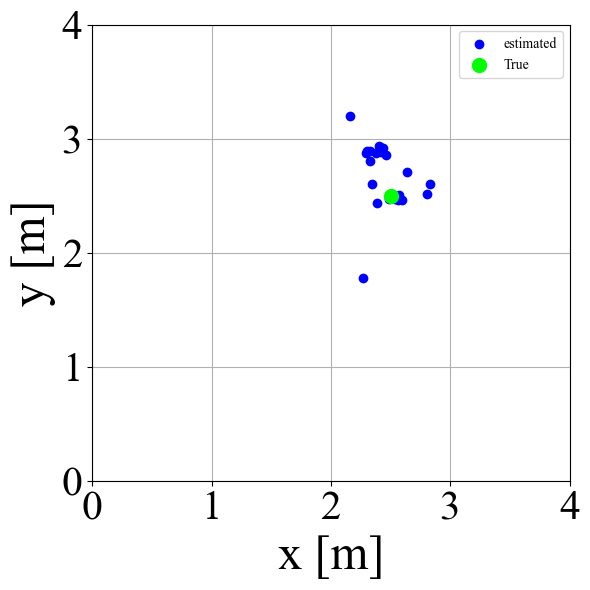

In [11]:
'''測位結果の可視化（散布図）'''

# 推定座標をxyに分割
pos_est_x = nn[(nn['x_lab'] == 2.5) & (nn['y_lab'] == 2.5)]['x_est']
pos_est_y = nn[(nn['x_lab'] == 2.5) & (nn['y_lab'] == 2.5)]['y_est']

# 散布図
plt.figure(figsize=(6, 6))
plt.grid()
plt.scatter(pos_est_x, pos_est_y, c="blue", label="estimated")
plt.scatter(2.5, 2.5, c="lime", s=100, label="True")
plt.xlabel('x [m]', fontsize=35)
plt.ylabel('y [m]', fontsize=35)
plt.xticks(np.arange(0, 5.0), fontsize= 30)
plt.yticks(np.arange(0, 5.0), fontsize= 30)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("figure/deeplearning_least_square/estimated_position_nn_pos2.png")

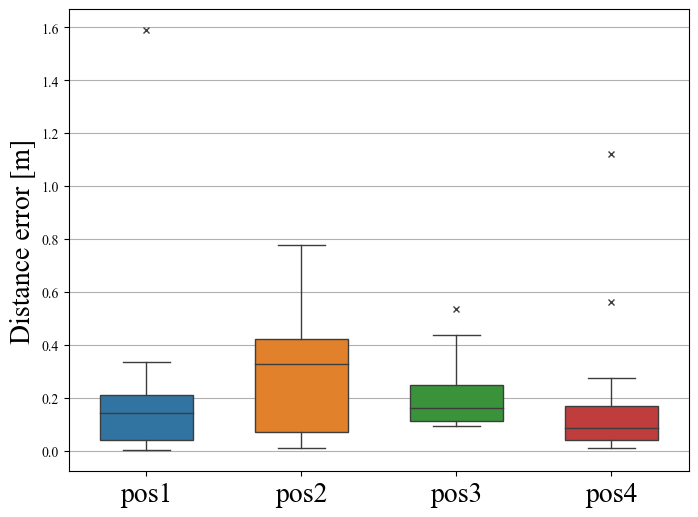

In [12]:
'''測位誤差の箱髭図'''

# 箱髭図用のデータフレーム
df_boxplot = pd.DataFrame({
            'pos1': nn['error'][(nn['x_lab'] == 1.5) & (nn['y_lab'] == 2.5)],
            'pos2': nn['error'][(nn['x_lab'] == 2.5) & (nn['y_lab'] == 2.5)],
            'pos3': nn['error'][(nn['x_lab'] == 1.5) & (nn['y_lab'] == 1.5)],
            'pos4': nn['error'][(nn['x_lab'] == 2.5) & (nn['y_lab'] == 1.5)],
        })

df_melt = pd.melt(df_boxplot)

# 箱髭図の作成
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_axisbelow(True)
sns.boxplot(x='variable', y='value', data=df_melt, ax=ax, width=0.6, flierprops={"marker": "x"}, fliersize=5, linewidth=1.0)
ax.set_xlabel('')
ax.set_ylabel('Distance error [m]', fontsize=20)
ax.set_xticklabels(["pos1", "pos2", "pos3", "pos4"], fontsize=20)
ax.grid(axis='y')
plt.savefig("figure/deeplearning_least_square/box_distance_error_nn.png")
plt.show()

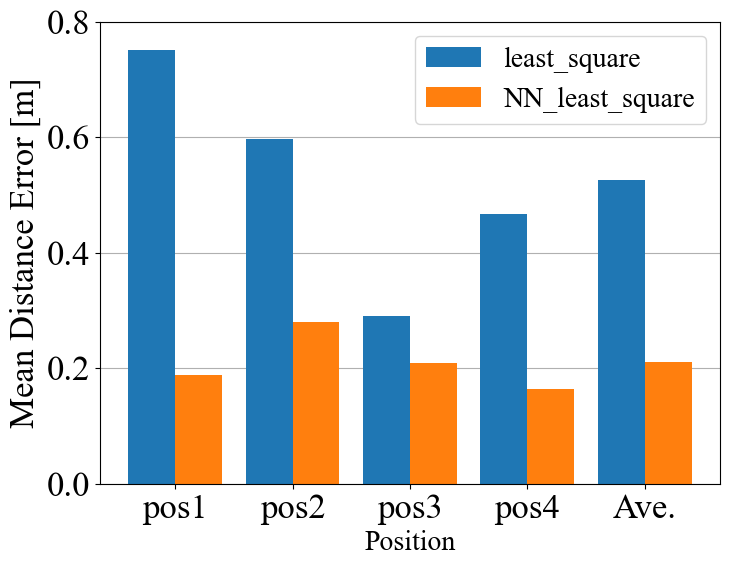

In [13]:
'''測位誤差の比較'''

# NN適用前の各地点の水平距離誤差
list_error = [0.751, 0.597, 0.291, 0.467, 0.526]

# NN適用後の各地点の水平距離誤差
list_error_nn = []

list_error_nn.append(nn['error'][(nn['x_lab'] == 1.5) & (nn['y_lab'] == 2.5)].mean())
list_error_nn.append(nn['error'][(nn['x_lab'] == 2.5) & (nn['y_lab'] == 2.5)].mean())
list_error_nn.append(nn['error'][(nn['x_lab'] == 1.5) & (nn['y_lab'] == 1.5)].mean())
list_error_nn.append(nn['error'][(nn['x_lab'] == 2.5) & (nn['y_lab'] == 1.5)].mean())

list_error_nn.append(sum(list_error_nn)/4)

# プロットするデータ
data = [list_error, list_error_nn]

#　軸の準備
xticks = np.arange(1,6)
positions = ['pos1', 'pos2', 'pos3', 'pos4', 'Ave.']

# 凡例
x_list = ['least_square', 'NN_least_square']

# マージンを設定
margin = 0.2
total_width = 1 - margin

plt.figure(figsize=(8, 6))
plt.rcParams['axes.axisbelow'] = True

# 棒グラフをプロット
for i, h in enumerate(data):
    pos = xticks - total_width * (1-(2*i+1)/len(data))/2
    plt.bar(pos, h, width=total_width/len(data), label=x_list[i])

# ラベルの設定
plt.xticks(xticks, positions, fontsize= 25) 
plt.yticks(np.arange(0, 1.0, 0.2), fontsize=25)
plt.xlabel('Position', fontsize=20)
plt.ylabel('Mean Distance Error [m]', fontsize=25)
plt.legend(fontsize=20)
plt.grid(axis='y')
plt.savefig("figure/deeplearning_least_square/bar_distance_error_ls_nn.png")